In [1]:
import numpy as np
import matplotlib.pyplot as plt

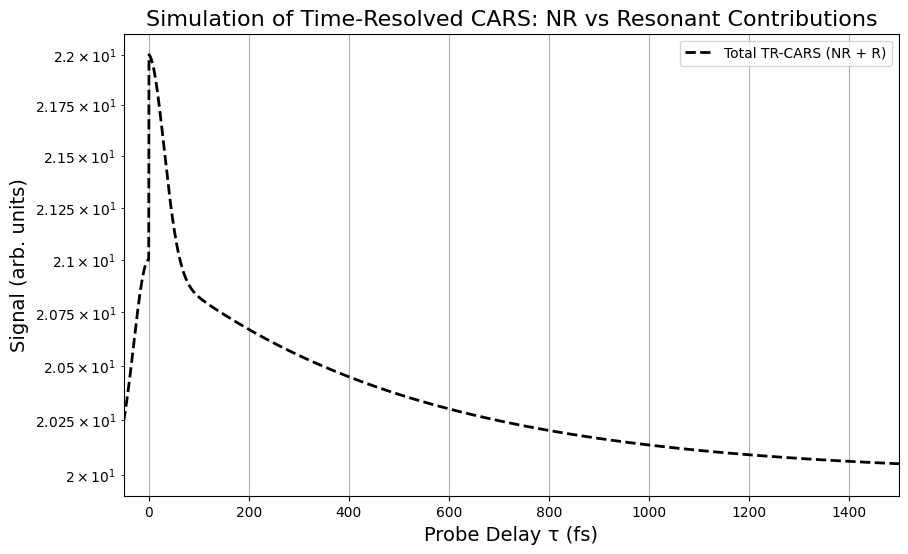

In [9]:
# -----------------------------
# Parameters
# -----------------------------

# Time-delay axis (fs)
tau = np.linspace(-200, 2000, 4000)  # from -200 fs to 2 ps

# Non-resonant (instantaneous) contribution
# fs-width Gaussian centered at delay=0
NR_width = 30  # fs
NR = np.exp(-(tau**2) / (2 * NR_width**2))+10

# Resonant contribution (vibrational coherence)
Gamma = 1/500  # Dephasing rate (1/fs), ~500 fs T2
T2 = 1/Gamma    # fs
Omega = 0    # frequency of oscillation (optional)
R = np.heaviside(tau, 0) * np.exp(-tau * Gamma) * (1 + 0.1*np.sin(Omega * tau))+10

# Total TR-CARS intensity (no interference term for simplicity)
I_total = NR + R

# -----------------------------
# Plotting
# -----------------------------

plt.figure(figsize=(10,6))

#plt.plot(tau, NR, label='Non-Resonant (instantaneous)', linewidth=2)
#plt.plot(tau, R, label='Resonant (vibrational coherence)', linewidth=2)
plt.plot(tau, I_total, '--k', label='Total TR-CARS (NR + R)', linewidth=2)

plt.xlim(-50, 1500)
#plt.ylim(0, 1.2)

plt.xlabel("Probe Delay τ (fs)", fontsize=14)
plt.ylabel("Signal (arb. units)", fontsize=14)
plt.title("Simulation of Time-Resolved CARS: NR vs Resonant Contributions", fontsize=16)
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


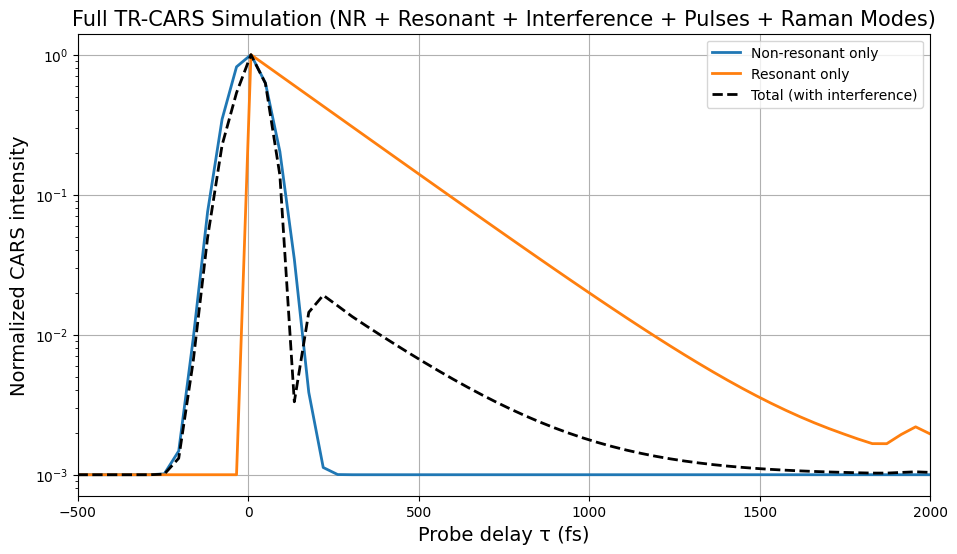

In [22]:

# -----------------------------------------------------------
# SIMULATION PARAMETERS
# -----------------------------------------------------------

# Time axis (fs)
t = np.linspace(-1000, 3000, 2000)  # covers fs to ps ranges
dt = t[1] - t[0]

# Pump, Stokes, Probe pulse durations (Gaussian, fs)
tau_pump  = 60
tau_stokes = 60
tau_probe  = 60

# Center times (pump & Stokes at 0, probe delayed later)
t0_p, t0_s = 0, 0

# User-controlled probe delay sweep (fs)
tau_delays = np.linspace(-500, 2000, 60)

# Non-resonant χ(3)
chi_NR = 1.0     # relative units (large NR background)

# Raman modes: frequencies Ω_k (rad/fs) and dephasing rates Γ_k
raman_modes = [
    {"Omega": 0.025, "Gamma": 1/500, "strength": 0.4}
]

# Phase-matching parameter (for thin sample)
delta_k = 0.0   # 0 = perfect phase matching


# -----------------------------------------------------------
# Gaussian pulse envelopes
# -----------------------------------------------------------
def gaussian_pulse(t, t0, width):
    return np.exp(-((t - t0)**2) / (2 * width**2))

pump  = gaussian_pulse(t, t0_p, tau_pump)
stokes = gaussian_pulse(t, t0_s, tau_stokes)


# -----------------------------------------------------------
# Build TR-CARS signal vs probe delay
# -----------------------------------------------------------

I_total = []
I_NR_only = []
I_R_only = []

for tau in tau_delays:

    probe = gaussian_pulse(t, tau, tau_probe)

    # -------------------------------------------------------
    # NON-RESONANT POLARIZATION
    # P_NR ~ χ_NR * Ep Es* Epr
    # -------------------------------------------------------
    P_NR = chi_NR * pump * np.conj(stokes) * probe

    # -------------------------------------------------------
    # RESONANT POLARIZATION
    # Solve dQ/dt = -ΓQ + iκ Ep Es*
    # with solution: Q(t) = convolution
            
    # -------------------------------------------------------
    P_R_total = np.zeros_like(t, dtype=complex)

    for mode in raman_modes:
        Omega = mode["Omega"]
        Gamma = mode["Gamma"]
        strength = mode["strength"]

        Raman_drive = pump * np.conj(stokes)

        # Green's function for vibrational response
        G = np.exp(-(Gamma + 1j*Omega) * (t - t[0]))
        G = np.heaviside(t - t[0], 0) * G

        # Convolution for Q(t)
        Q = np.convolve(np.heaviside(tau,1)*Raman_drive, G, mode='same') * dt

        # Resonant P^(3)
        P_R = strength * Q * probe
        P_R_total += P_R

    # -------------------------------------------------------
    # Phase matching factor (thin sample)
    # -------------------------------------------------------
    phase = np.exp(1j * delta_k)

    # -------------------------------------------------------
    # Anti-Stokes field (thin sample: E ~ ∫P dt)
    # -------------------------------------------------------
    E_as = phase * np.trapz(P_NR + P_R_total, t)

    # Store intensities
    I_total.append(np.abs(E_as)**2)
    I_NR_only.append(np.abs(np.trapz(P_NR, t))**2)
    I_R_only.append(np.abs(np.trapz(P_R_total, t))**2)


I_total = np.array(I_total)
I_NR_only = np.array(I_NR_only)
I_R_only = np.array(I_R_only)


# -----------------------------------------------------------
# PLOTS
# -----------------------------------------------------------

plt.figure(figsize=(11,6))
plt.plot(tau_delays, I_NR_only / I_NR_only.max() + 0.001, label="Non-resonant only", linewidth=2)
plt.plot(tau_delays, I_R_only / I_R_only.max() + 0.001,   label="Resonant only", linewidth=2)
plt.plot(tau_delays, I_total / I_total.max() + 0.001, '--k', label="Total (with interference)", linewidth=2)

plt.xlabel("Probe delay τ (fs)", fontsize=14)
plt.ylabel("Normalized CARS intensity", fontsize=14)
plt.title("Full TR-CARS Simulation (NR + Resonant + Interference + Pulses + Raman Modes)", fontsize=15)
plt.xlim(-500, 2000)
plt.grid()
plt.legend()
plt.yscale('log')
plt.show()


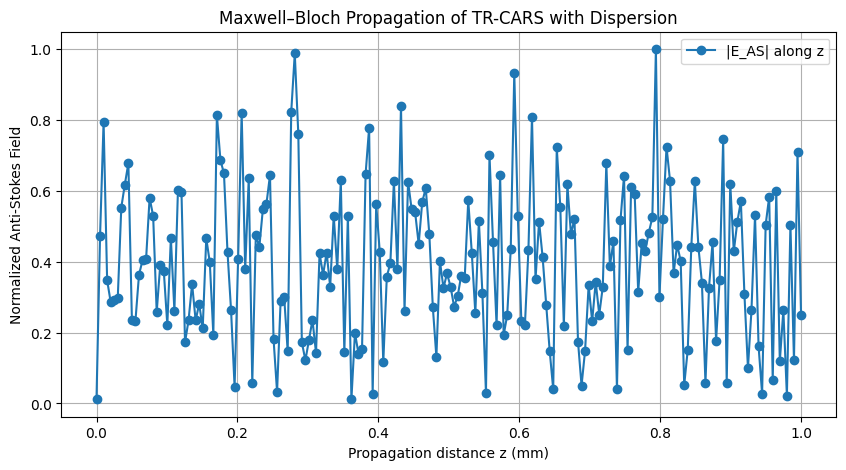

In [23]:

# -----------------------------
# 1. Simulation parameters
# -----------------------------
c = 3e8  # m/s

# Time grid
t_min, t_max, Nt = -1000, 3000, 16384
t = np.linspace(t_min, t_max, Nt)  # fs
dt = t[1] - t[0]  # fs
freq = np.fft.fftfreq(Nt, dt*1e-15)  # Hz
omega = 2*np.pi*freq  # rad/s

# z propagation grid
L = 0.001  # sample thickness (m)
Nz = 200
dz = L / Nz

# Pulses (Gaussian)
def gaussian_pulse(t, t0, width, amplitude=1.0):
    return amplitude * np.exp(-(t - t0)**2 / (2*width**2))

# Pump/Stokes/probe pulse durations
tau_p, tau_s, tau_pr = 50, 50, 50  # fs
E_p0 = gaussian_pulse(t, 0, tau_p)
E_s0 = gaussian_pulse(t, 0, tau_s)
E_pr0 = gaussian_pulse(t, 200, tau_pr)  # probe delayed

# Non-resonant susceptibility
chi_NR = 1.0

# Raman modes: Omega (rad/fs), Gamma (fs^-1), strength
raman_modes = [
    {"Omega": 0.025, "Gamma": 1/500, "strength": 0.5},
    {"Omega": 0.018, "Gamma": 1/300, "strength": 0.3},
]

# Dispersion (GVD) in fs^2/m, simple approximation
GVD = 1000  # fs^2/m, for demonstration
k_omega = 0.5 * GVD * (omega - omega[int(Nt/2)])**2

# -----------------------------
# 2. Initialize fields
# -----------------------------
E_p = E_p0.copy()
E_s = E_s0.copy()
E_pr = E_pr0.copy()

# Initialize Raman coherences Q_k(t)
Q_k = [np.zeros_like(t, dtype=complex) for _ in raman_modes]

# Storage for output anti-Stokes
E_as_z = []

# -----------------------------
# 3. Propagate along z
# -----------------------------
for iz in range(Nz):
    # 3a. Update Raman coherences
    for i, mode in enumerate(raman_modes):
        Omega = mode["Omega"]
        Gamma = mode["Gamma"]
        kappa = mode["strength"]
        dQ = (-Gamma - 1j*Omega) * Q_k[i] + 1j*kappa*E_p* np.conj(E_s)
        Q_k[i] += dQ * dz*1e-3  # scaling factor for units
    
    # 3b. Compute nonlinear polarizations
    P_NR = chi_NR * E_p * np.conj(E_s) * E_pr
    P_R = np.zeros_like(t, dtype=complex)
    for i, mode in enumerate(raman_modes):
        P_R += Q_k[i] * E_pr * mode["strength"]
    
    P_total = P_NR + P_R
    
    # 3c. Apply linear propagation with dispersion (split-step)
    P_freq = np.fft.fft(P_total)
    phase_shift = np.exp(1j * k_omega * dz)  # dispersion phase
    P_freq_prop = P_freq * phase_shift
    E_pr = np.fft.ifft(np.fft.fft(E_pr) * phase_shift + P_freq_prop*dz)  # thin-sample approximation
    
    # Store anti-Stokes at this z-step (approx)
    E_as_z.append(np.trapz(P_total, t))

# -----------------------------
# 4. Plot results
# -----------------------------
E_as_z = np.array(E_as_z)
z_grid = np.linspace(0, L*1e3, Nz)  # mm

plt.figure(figsize=(10,5))
plt.plot(z_grid, np.abs(E_as_z)/np.max(np.abs(E_as_z)), '-o', label='|E_AS| along z')
plt.xlabel("Propagation distance z (mm)")
plt.ylabel("Normalized Anti-Stokes Field")
plt.title("Maxwell–Bloch Propagation of TR-CARS with Dispersion")
plt.grid(True)
plt.legend()
plt.show()


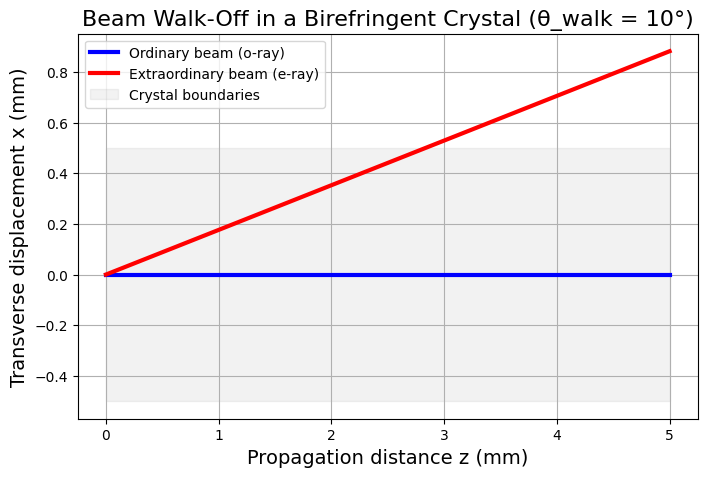

In [24]:
# -----------------------------
# Parameters
# -----------------------------
L = 5.0          # crystal length (mm)
theta_walk = 10  # walk-off angle for extraordinary beam (degrees)
N = 500          # number of points along crystal

# -----------------------------
# Crystal axis (reference)
# -----------------------------
z = np.linspace(0, L, N)  # propagation distance along crystal

# -----------------------------
# Beam positions
# -----------------------------
# Ordinary beam (no walk-off)
x_o = np.zeros_like(z)

# Extraordinary beam (walk-off)
theta_rad = np.radians(theta_walk)
x_e = z * np.tan(theta_rad)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(z, x_o, 'b', linewidth=3, label='Ordinary beam (o-ray)')
plt.plot(z, x_e, 'r', linewidth=3, label='Extraordinary beam (e-ray)')

# Crystal boundary
plt.fill_between([0,L], -0.5, 0.5, color='gray', alpha=0.1, label='Crystal boundaries')

plt.xlabel("Propagation distance z (mm)", fontsize=14)
plt.ylabel("Transverse displacement x (mm)", fontsize=14)
plt.title(f"Beam Walk-Off in a Birefringent Crystal (θ_walk = {theta_walk}°)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (500,) and (200, 500)

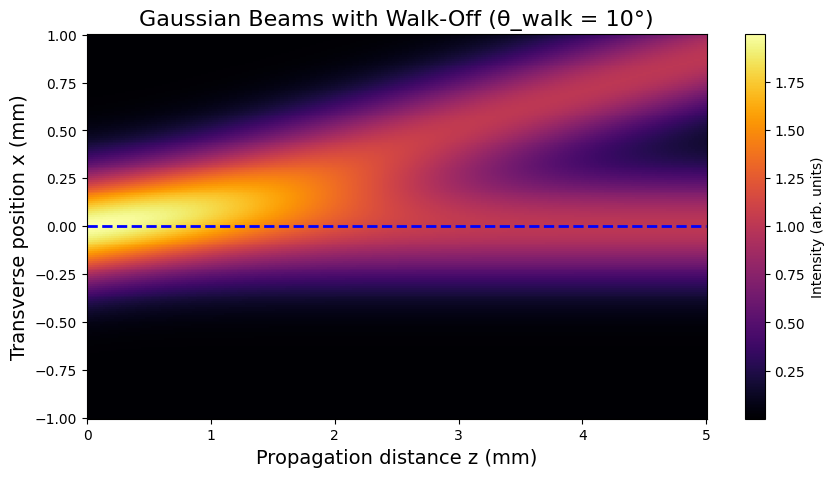

In [26]:
# -----------------------------
# Parameters
# -----------------------------
L = 5.0          # crystal length (mm)
theta_walk = 10  # walk-off angle (degrees)
N_z = 500        # z-axis points
N_x = 200        # x-axis points
w0 = 0.2         # beam waist (mm)

# -----------------------------
# Coordinates
# -----------------------------
z = np.linspace(0, L, N_z)
x = np.linspace(-1, 1, N_x)  # transverse axis (mm)
Z, X = np.meshgrid(z, x)

# -----------------------------
# Beam positions
# -----------------------------
theta_rad = np.radians(theta_walk)
x_e_center = Z * np.tan(theta_rad)
x_o_center = np.zeros_like(z)

# -----------------------------
# Gaussian beam envelopes
# -----------------------------
# Ordinary beam
E_o = np.exp(-((X - x_o_center[np.newaxis, :])**2) / (2*w0**2))

# Extraordinary beam
E_e = np.exp(-((X - x_e_center)**2) / (2*w0**2))

# -----------------------------
# Total intensity
# -----------------------------
I_total = E_o + E_e

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,5))
plt.pcolormesh(Z, X, I_total, shading='auto', cmap='inferno')
plt.colorbar(label='Intensity (arb. units)')
plt.xlabel("Propagation distance z (mm)", fontsize=14)
plt.ylabel("Transverse position x (mm)", fontsize=14)
plt.title(f"Gaussian Beams with Walk-Off (θ_walk = {theta_walk}°)", fontsize=16)

# Add beam center lines
plt.plot(z, x_o_center, 'b--', linewidth=2, label='o-ray center')
plt.plot(z, x_e_center, 'r--', linewidth=2, label='e-ray center')
plt.legend()
plt.show()
